In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-24 15:46:57.064516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 15:46:57.064533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('./data/ouput.csv')

In [3]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000168,2011-11-24 13:30:00,0.054
1,MAC000168,2011-11-24 14:00:00,0.178
2,MAC000168,2011-11-24 14:30:00,0.113
3,MAC000168,2011-11-24 15:00:00,0.068
4,MAC000168,2011-11-24 15:30:00,0.061


In [4]:
df.shape

(396552, 3)

In [5]:
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
max_value_energy


4.595

In [6]:
#max value for hh doesnt compare with hourly
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)

In [7]:
# Sorting the values
#df.sort_values('tstp', inplace=True)

In [8]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000168,2011-11-24 13:30:00,0.054
1,MAC000168,2011-11-24 14:00:00,0.178
2,MAC000168,2011-11-24 14:30:00,0.113
3,MAC000168,2011-11-24 15:00:00,0.068
4,MAC000168,2011-11-24 15:30:00,0.061


In [9]:
df['energy(kWh/hh)'].max()

4.595

In [10]:
df['energy(kWh/hh)'].min()

0.0

In [11]:
from ML_classes.LSTMModel import LSTMModel

In [12]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
#hh = hh.set_index("tstp")
#hh = hh.resample("H").sum()
#hh = hh.reset_index()

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)

/tmp/ipykernel_68334/194026773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)


In [13]:
#normalizedtstp = (hh["tstp"] - hh["tstp"].mean()) / hh["tstp"].std()
#normalizedtstp
type(hh.iloc[0]["energy(kWh/hh)"])

numpy.float64

In [14]:
# Initiating the class
deep_learner = LSTMModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 48,
LSTM_layer_depth = 50,
epochs =20,
batch_size = 256,
train_test_split = 0.15
)


In [15]:
# Fitting the model

model = deep_learner.LSTModel()

2022-03-24 15:47:00.105984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 15:47:00.106429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 15:47:00.106481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-24 15:47:00.106524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-24 15:47:00.106564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/20
132/132 [==============================] - 4s 22ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 2/20
132/132 [==============================] - 3s 21ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 3/20
132/132 [==============================] - 3s 22ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 4/20
132/132 [==============================] - 3s 21ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 5/20
132/132 [==============================] - 3s 22ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 6/20
132/132 [==============================] - 3s 22ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 7/20
132/132 [==============================] - 3s 22ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 8/20
132/132 [==============================] - 3s 22ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 9/20
132/132 [==============================] - 3s 22ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 10/20
132/132 [==============================] - 3s 22ms/step - loss: 0.0043 - val_lo

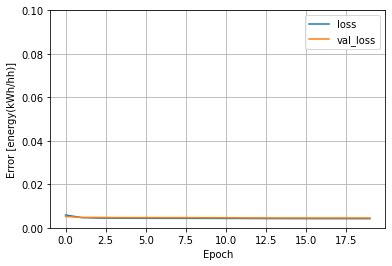

In [16]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)
plot_loss(deep_learner.history)

In [18]:
# Defining the lag that we used for training of the model 
lag_model = 48
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)
yhat

array([[0.04493178]], dtype=float32)

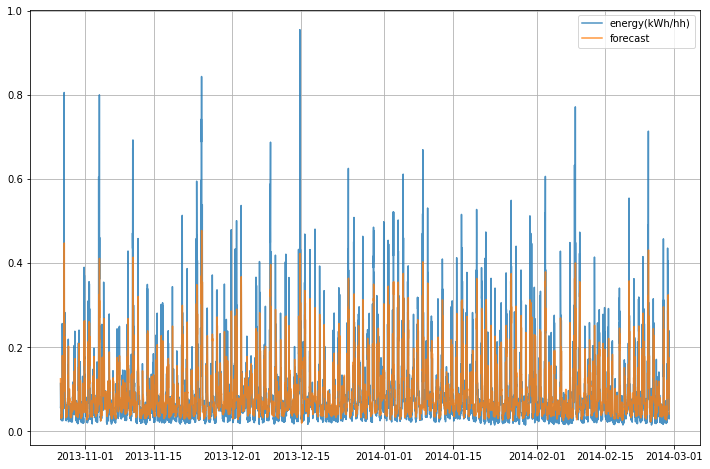

In [19]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_68334/370916521.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


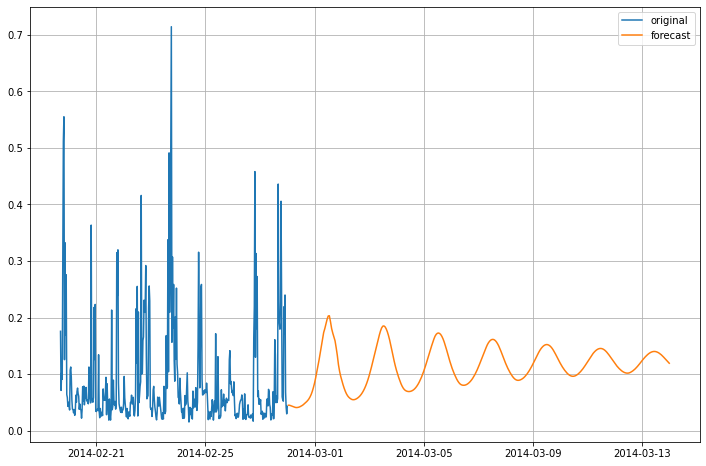

In [21]:


# Forecasting n steps ahead
n_ahead = 168*2
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

# Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)

# Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [ ]:
#deep_learner.save_lstm_model()

In [ ]:
deep_learner.evaluateMSE()

In [ ]:
deep_learner.evaluateRMSE()

In [ ]:
deep_learner.evaluateMAE()

In [ ]:
deep_learner.evaluateMAPE()

In [ ]:
#train for all houses
lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in lclid_list:
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()

    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    
    # Initiating the class
    deep_learner = LSTMModel(
        data = hh,
        Y_var = 'energy(kWh/hh)',
        lag = 24,
        LSTM_layer_depth = 50,
        epochs =20,
        batch_size = 256,
        train_test_split = 0.15
    )
    #training
    model = deep_learner.LSTModel()
    
    mse.append(deep_learner.evaluateMSE())
    rmse.append(deep_learner.evaluateRMSE())
    mae.append(deep_learner.evaluateMAE())
    mape.append(deep_learner.evaluateMAPE())
houses = pd.Series(data=lclid_list,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape


In [ ]:
res_df